In [1]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [14]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0)
R = np.transpose(np.array(R))
RR = R
for j in range(0,470): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

L = []
for j in range(0,R.shape[1]):
    L.append(1.0/np.sqrt(R[j,j]))
L = np.diag(L)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

elow_keV = 70
ehigh_keV = 1000
xspace_estep_keV = 1
espace_estep_keV = 50

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,500,R.shape[0])

response condition number: 15993.388434455901
response condition number after preconditioning: 173.12830996456856


In [28]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

curve_vals = []

def f_of_w(w):
    cc = np.linalg.cond(np.matmul(w,R))
    clear_output(wait=True)
    display(cc)
    curve_vals.append(cc)
    return(cc)

def toVector(w):
    vv = np.diag(w)
    return vv

def toW(vec):
    return np.diag(vec)

def doOptimization(f_of_w, w0):
    def f(x): 
        w = toW(x)
        return f_of_w(w)

    result = minimize(f, toVector(w0),method='CG', options={'maxiter':100})
    # Different optimize functions return their
    # vector result differently. In this case it's result.x:
    result.x = toW(result.x) 
    return result

In [29]:
res = doOptimization(f_of_w, np.identity(470))

KeyboardInterrupt: 

Text(0.5, 1.0, 'Response Matrix Singular Values\n Diagonal Preconditioning')

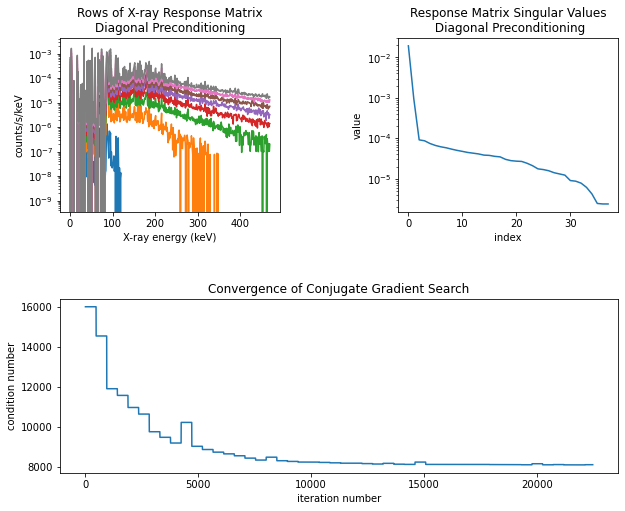

In [51]:
fig = plt.figure(figsize=(10,8))
gs = plt.GridSpec(nrows=2, ncols=2,hspace=.5,wspace=.54)

ax1 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])


RT = np.matmul(left_precond_opt,R)

for i in range(1,R.shape[1],5):
    ax3.semilogy(RT[:,i])
ax4.semilogy(np.linalg.svd(RT)[1])

ax1.plot(curve_vals)

ax1.set_title('Convergence of Conjugate Gradient Search')
ax1.set_xlabel('iteration number')
ax1.set_ylabel('condition number')

ax3.set_title('Rows of X-ray Response Matrix\nDiagonal Preconditioning')
ax3.set_ylabel('counts/s/keV')
ax3.set_xlabel('X-ray energy (keV)')
ax4.set_ylabel('value')
ax4.set_xlabel('index')
ax4.set_title('Response Matrix Singular Values\n Diagonal Preconditioning')


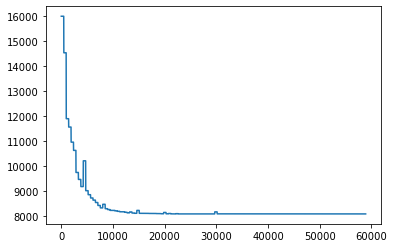

In [21]:
plt.plot(curve_vals)

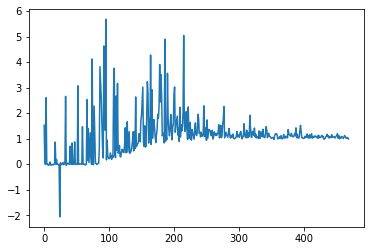

In [31]:
plt.plot(np.diag(res.x))

In [38]:
np.linalg.cond(RT)

8082.0641267222245

In [39]:
np.linalg.cond(R)

15993.388434455901